# Introduction

This notebook contains the process of developing a sophisticated Deep Learning (DL) model for predicting customer churn in the telecom industry.

This project is structured into three key phases:

1. Exploratory Data Analysis (EDA): Exploring the dataset to gain insights, helps understanding the foundation for building the models.
2. Data Preprocessing: Handling missing values, encode categorical features, and perform other necessary transformations.
3. Model Training and Evaluation: Building predictive models using Machine Learning (ML) algorithms as our baseline. Then building Deep Learning model for comparison through accuracy and classification reports.

# Import data and libraries

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
    Input,
    Bidirectional,
    LSTM,
)
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import swish
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import warnings
import joblib

# Configuration

In [ ]:
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

# Functions

In [19]:
# Plot accuracy and loss
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

# Loading data

In [2]:
df_master = pd.read_csv("../data/Train.csv")
df = df_master.copy()
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


# Exploratory Data Analysis

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   REGION          object 
 2   TENURE          object 
 3   MONTANT         float64
 4   FREQUENCE_RECH  float64
 5   REVENUE         float64
 6   ARPU_SEGMENT    float64
 7   FREQUENCE       float64
 8   DATA_VOLUME     float64
 9   ON_NET          float64
 10  ORANGE          float64
 11  TIGO            float64
 12  ZONE1           float64
 13  ZONE2           float64
 14  MRG             object 
 15  REGULARITY      int64  
 16  TOP_PACK        object 
 17  FREQ_TOP_PACK   float64
 18  CHURN           int64  
dtypes: float64(12), int64(2), object(5)
memory usage: 312.2+ MB


## Null Analysis

In [23]:
round(df.isna().sum().sort_values(ascending=False) / len(df), 4) * 100

ZONE2             93.65
ZONE1             92.12
TIGO              59.89
DATA_VOLUME       49.23
FREQ_TOP_PACK     41.90
TOP_PACK          41.90
ORANGE            41.56
REGION            39.43
ON_NET            36.52
MONTANT           35.13
FREQUENCE_RECH    35.13
REVENUE           33.71
ARPU_SEGMENT      33.71
FREQUENCE         33.71
REGULARITY         0.00
user_id            0.00
MRG                0.00
TENURE             0.00
CHURN              0.00
dtype: float64

## Categorical

In [24]:
cat_df_filled = df[["TOP_PACK", "REGION"]].fillna(value="Missing")

In [25]:
df.TOP_PACK.unique()

array(['On net 200F=Unlimited _call24H', nan, 'On-net 1000F=10MilF;10d',
       'Data:1000F=5GB,7d', 'Mixt 250F=Unlimited_call24H',
       'MIXT:500F= 2500F on net _2500F off net;2d',
       'All-net 500F=2000F;5d', 'On-net 500F_FNF;3d',
       'Data: 100 F=40MB,24H', 'MIXT: 200mnoff net _unl on net _5Go;30d',
       'Jokko_Daily', 'Data: 200 F=100MB,24H', 'Data:490F=1GB,7d',
       'Twter_U2opia_Daily', 'On-net 500=4000,10d', 'Data:1000F=2GB,30d',
       'IVR Echat_Daily_50F', 'Pilot_Youth4_490',
       'All-net 500F =2000F_AllNet_Unlimited', 'Twter_U2opia_Weekly',
       'Data:200F=Unlimited,24H', 'On-net 200F=60mn;1d',
       'All-net 600F= 3000F ;5d', 'Pilot_Youth1_290',
       'All-net 1000F=(3000F On+3000F Off);5d', 'VAS(IVR_Radio_Daily)',
       'Data:3000F=10GB,30d', 'All-net 1000=5000;5d',
       'Twter_U2opia_Monthly', 'MIXT: 390F=04HOn-net_400SMS_400 Mo;4h\t',
       'FNF2 ( JAPPANTE)', 'Yewouleen_PKG', 'Data:150F=SPPackage1,24H',
       'WIFI_Family_2MBPS', 'Data:500F=2GB,2

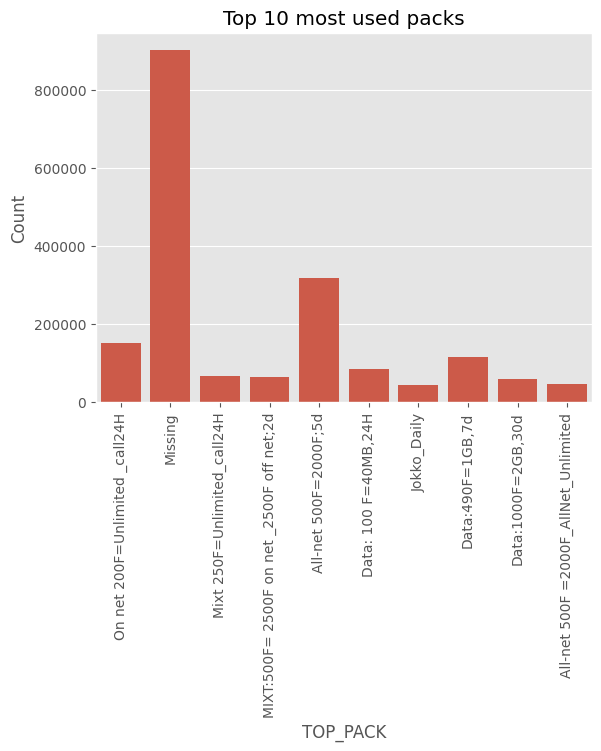

In [26]:
# Only show top 10
top_n = 10  

# Get the top values
top_packs = cat_df_filled['TOP_PACK'].value_counts(ascending=True).nlargest(top_n).index

# Filter
cat_df_top_n = cat_df_filled[cat_df_filled['TOP_PACK'].isin(top_packs)]

sns.countplot(data=cat_df_top_n, x="TOP_PACK")
plt.title("Top 10 most used packs")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [27]:
df.REGION.unique() 

array(['FATICK', nan, 'DAKAR', 'LOUGA', 'TAMBACOUNDA', 'KAOLACK', 'THIES',
       'SAINT-LOUIS', 'KOLDA', 'KAFFRINE', 'DIOURBEL', 'ZIGUINCHOR',
       'MATAM', 'SEDHIOU', 'KEDOUGOU'], dtype=object)

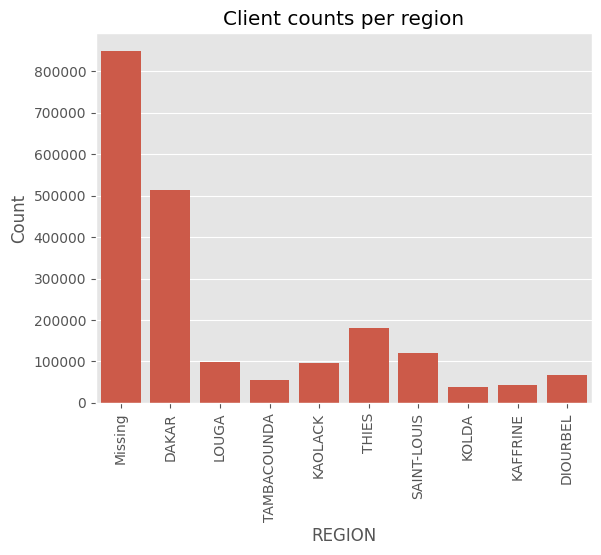

In [28]:
# Get the top values
top_packs = cat_df_filled['REGION'].value_counts(ascending=True).nlargest(top_n).index

# Filter
cat_df_top_n = cat_df_filled[cat_df_filled['REGION'].isin(top_packs)]

sns.countplot(data=cat_df_top_n, x="REGION")
plt.title("Client counts per region")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [29]:
df.MRG.unique()

array(['NO'], dtype=object)

## Numerical

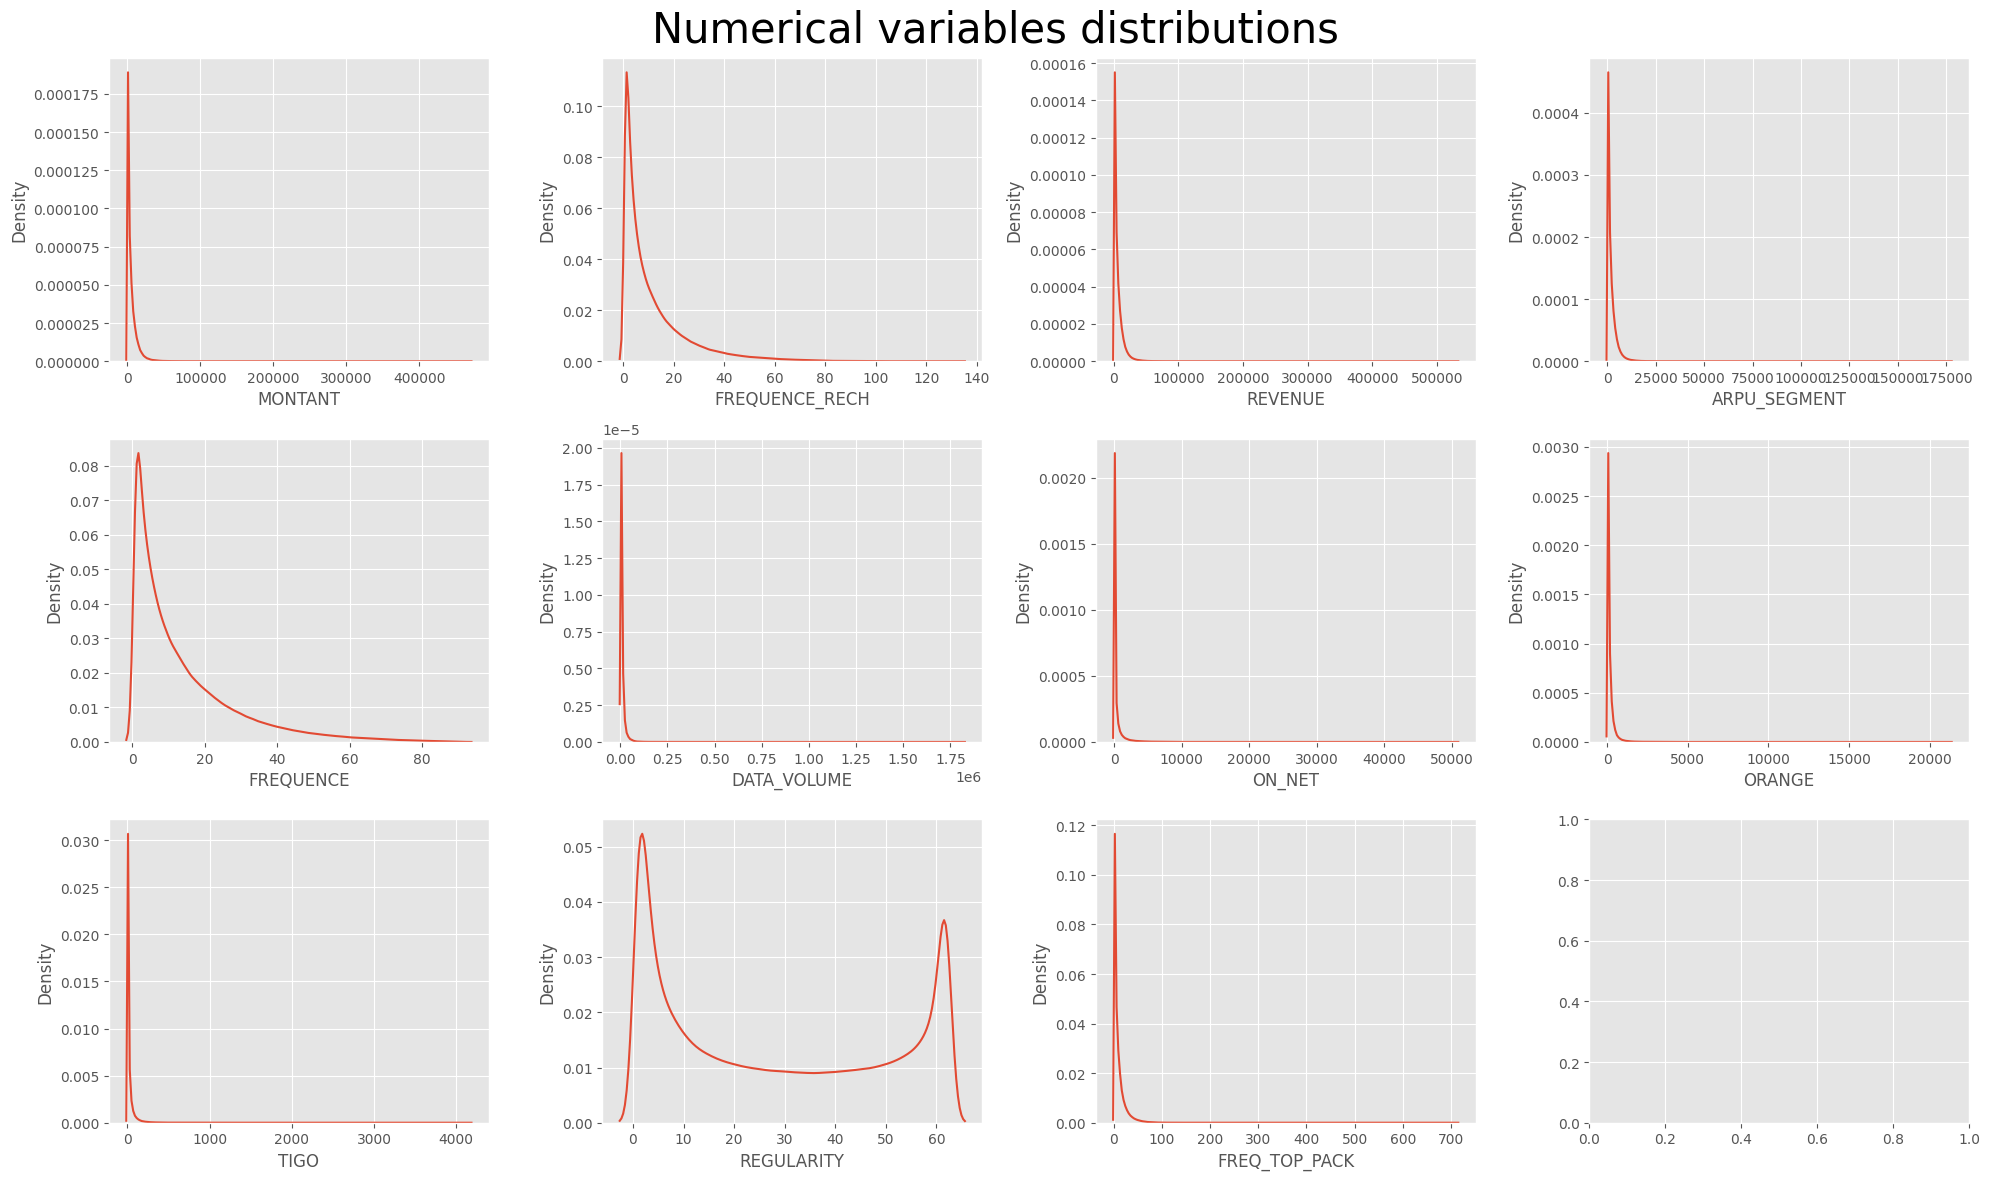

In [30]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

sns.kdeplot(data=df, x="MONTANT", ax=axes[0, 0])
sns.kdeplot(data=df, x="FREQUENCE_RECH", ax=axes[0, 1])
sns.kdeplot(data=df, x="REVENUE", ax=axes[0, 2])
sns.kdeplot(data=df, x="ARPU_SEGMENT", ax=axes[0, 3])

sns.kdeplot(data=df, x="FREQUENCE", ax=axes[1, 0])
sns.kdeplot(data=df, x="DATA_VOLUME", ax=axes[1, 1])
sns.kdeplot(data=df, x="ON_NET", ax=axes[1, 2])
sns.kdeplot(data=df, x="ORANGE", ax=axes[1, 3])

sns.kdeplot(data=df, x="TIGO", ax=axes[2, 0])
sns.kdeplot(data=df, x="REGULARITY", ax=axes[2, 1])
sns.kdeplot(data=df, x="FREQ_TOP_PACK", ax=axes[2, 2])

plt.suptitle("Numerical variables distributions", fontsize=30)
plt.tight_layout()
plt.show()

## Target

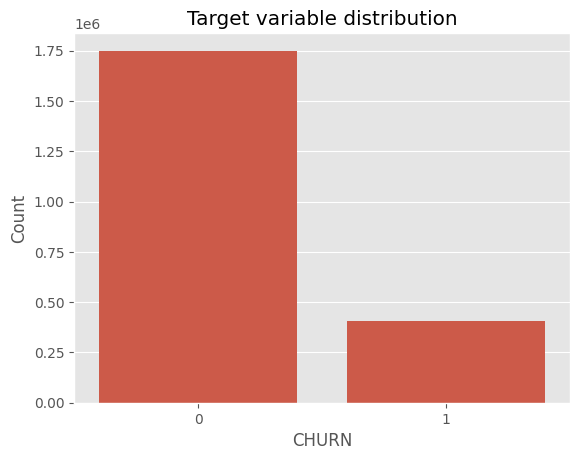

In [31]:
sns.countplot(data=df, x="CHURN")
plt.title("Target variable distribution")
plt.ylabel("Count")
plt.show()

> Comments: The target variable shows an imbalance distribution case. All the numerical variables are right-skewed. There are lots of null values in most of the features.

# Data preprocessing

In this step, the chosen approach for preparing the data are:

* Dropping null columns with more than 80%.
* Filling null values, with categorical it's "Missing" and with numerical it's "Mean".
* Encoding categorical variables with one-hot encoding.
* Normalizing numerical variables with StandardScaler.


## Splitting dataset

In [3]:
X = df.drop(["user_id", "MRG", "ZONE1", "ZONE2", "CHURN"], axis=1)
y = df.CHURN

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(f'Train size: {X_train.shape}')
print(f'Test size: {X_test.shape}')

Train size: (2046345, 14)
Test size: (107703, 14)


## Preprocessing

In [14]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        # Impute missing values in categorical columns and then apply one-hot encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols),
        # Impute missing values in numerical columns and then apply scaling
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols)
    ], remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
joblib.dump(preprocessor, 'preprocessor.joblib')
X_test_processed = preprocessor.transform(X_test)

In [35]:
""" Resampling
oversampling = SMOTE(random_state=42, k_neighbors=3, n_jobs=-1)
X_resampled, y_resampled = oversampling.fit_resample(X_train_processed, y_train)

print(f'Size after resampling: {X_resampled.shape}')
print(f'Size before resampling: {X_train_processed.shape}')
"""

" Resampling\noversampling = SMOTE(random_state=42, k_neighbors=3, n_jobs=-1)\nX_resampled, y_resampled = oversampling.fit_resample(X_train_processed, y_train)\n\nprint(f'Size after resampling: {X_resampled.shape}')\nprint(f'Size before resampling: {X_train_processed.shape}')\n"

# Loss & Metric

# Model Training

As discussed earlier, the traditional ML will be our baseline, here we chose the popular algorithms such as Random Forest, XGBoost.

## Traditional

In [36]:
xgb = XGBClassifier(n_jobs=-1)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [37]:
#xgb.fit(X_resampled, y_resampled)
xgb.fit(X_train_processed, y_train)
y_pred_xgb = xgb.predict(X_test_processed)

In [38]:
#rf.fit(X_resampled, y_resampled)
rf.fit(X_train_processed, y_train)
y_pred_rf = rf.predict(X_test_processed)

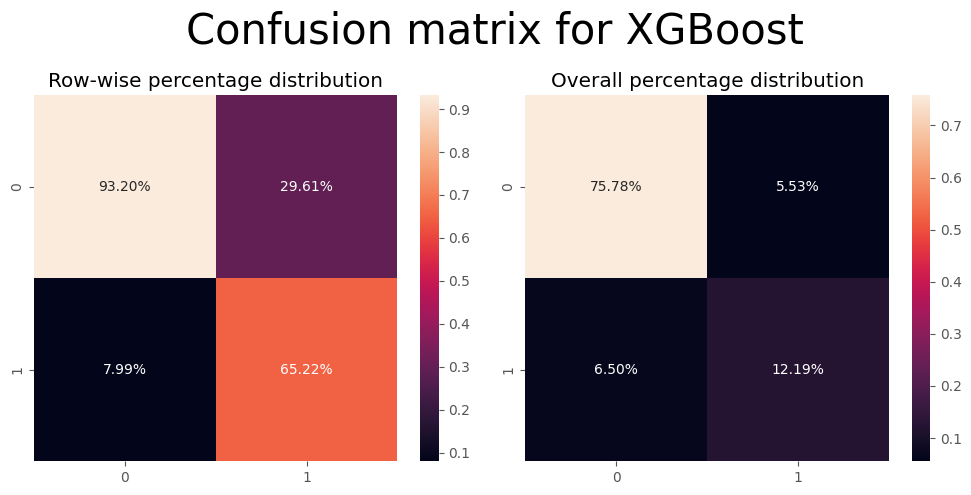

Accuracy: 0.8796783747899316


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb_perc = cm_xgb / cm_xgb.sum(axis=1)

sns.heatmap(cm_xgb_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for XGBoost", fontsize=30)
plt.tight_layout()
plt.show()

print(f'Accuracy: {xgb.score(X_test_processed, y_test)}')

In [40]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93     87579
           1       0.69      0.65      0.67     20124

    accuracy                           0.88    107703
   macro avg       0.80      0.79      0.80    107703
weighted avg       0.88      0.88      0.88    107703


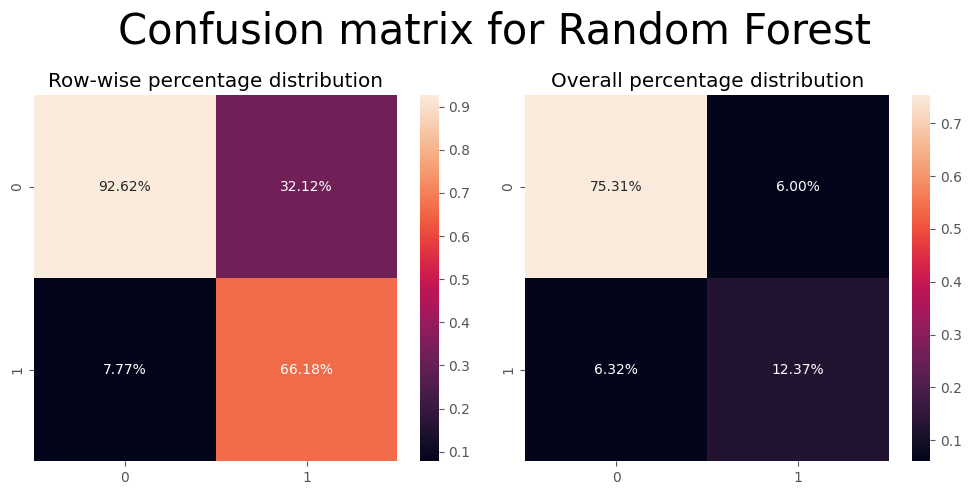

Accuracy: 0.8768000891340074


In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_perc = cm_rf / cm_rf.sum(axis=1)

sns.heatmap(cm_rf_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_rf, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for Random Forest", fontsize=30)
plt.tight_layout()
plt.show()

print(f'Accuracy: {rf.score(X_test_processed, y_test)}')

In [42]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     87579
           1       0.67      0.66      0.67     20124

    accuracy                           0.88    107703
   macro avg       0.80      0.79      0.80    107703
weighted avg       0.88      0.88      0.88    107703


In [43]:
acc_xgb = accuracy_score(y_test, y_pred_xgb)
acc_rf = accuracy_score(y_test, y_pred_rf)

> Comments: The baseline models performed well with a good accuracy but not able to have a good prediction on the label "churned".

## Deep learning

We will build an ensemble model with the combination of a DNN and an Bidirectional LSTM RNN.

In [10]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

### DNN

In [45]:
dnn = Sequential()

# Input layer
#dnn.add(Dense(1024, input_dim=X_resampled.shape[1], activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(Dense(1024, input_dim=X_train_processed.shape[1], activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(BatchNormalization())

# Hidden layers
dnn.add(Dense(512, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(Dropout(0.3))  
dnn.add(BatchNormalization())

dnn.add(Dense(256, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001)))
dnn.add(Dropout(0.3))  
dnn.add(BatchNormalization())

# Output layer
dnn.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              180224    
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               1

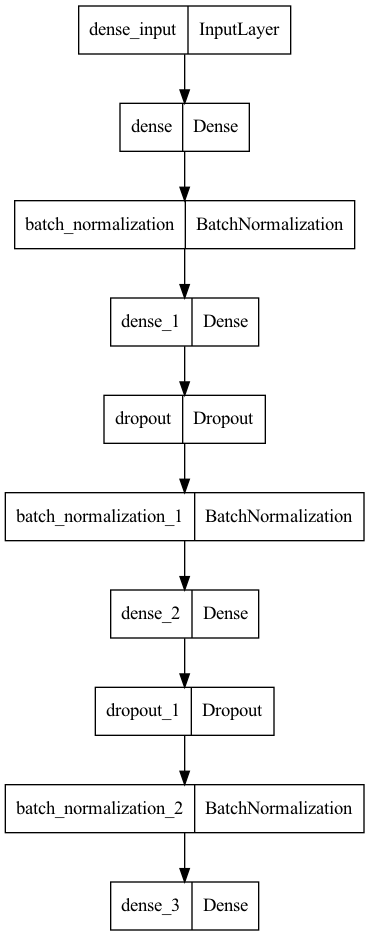

In [46]:
plot_model(dnn, to_file="../dnn.png")

In [47]:
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
with tf.device('/cpu:0'):
    history_dnn = dnn.fit(X_train_processed, y_train, epochs=10, batch_size=128, validation_split=0.05, callbacks=[early_stopping])
    #history_dnn = dnn.fit(X_resampled, y_resampled, epochs=10, batch_size=128, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/10
15188/15188 [==============================] - 128s 8ms/step - loss: 0.3131 - accuracy: 0.8737 - val_loss: 0.2713 - val_accuracy: 0.8742
Epoch 2/10
15188/15188 [==============================] - 120s 8ms/step - loss: 0.2669 - accuracy: 0.8760 - val_loss: 0.2654 - val_accuracy: 0.8745
Epoch 3/10
15188/15188 [==============================] - 114s 8ms/step - loss: 0.2660 - accuracy: 0.8755 - val_loss: 0.2629 - val_accuracy: 0.8759
Epoch 4/10
15188/15188 [==============================] - 114s 8ms/step - loss: 0.2657 - accuracy: 0.8756 - val_loss: 0.2656 - val_accuracy: 0.8774
Epoch 5/10
15188/15188 [==============================] - 125s 8ms/step - loss: 0.2653 - accuracy: 0.8760 - val_loss: 0.2631 - val_accuracy: 0.8771
Epoch 6/10
15188/15188 [==============================] - 122s 8ms/step - loss: 0.2650 - accuracy: 0.8761 - val_loss: 0.2633 - val_accuracy: 0.8773
Epoch 7/10
15188/15188 [==============================] - 138s 9ms/step - loss: 0.2648 - accuracy: 0.8763 - val_

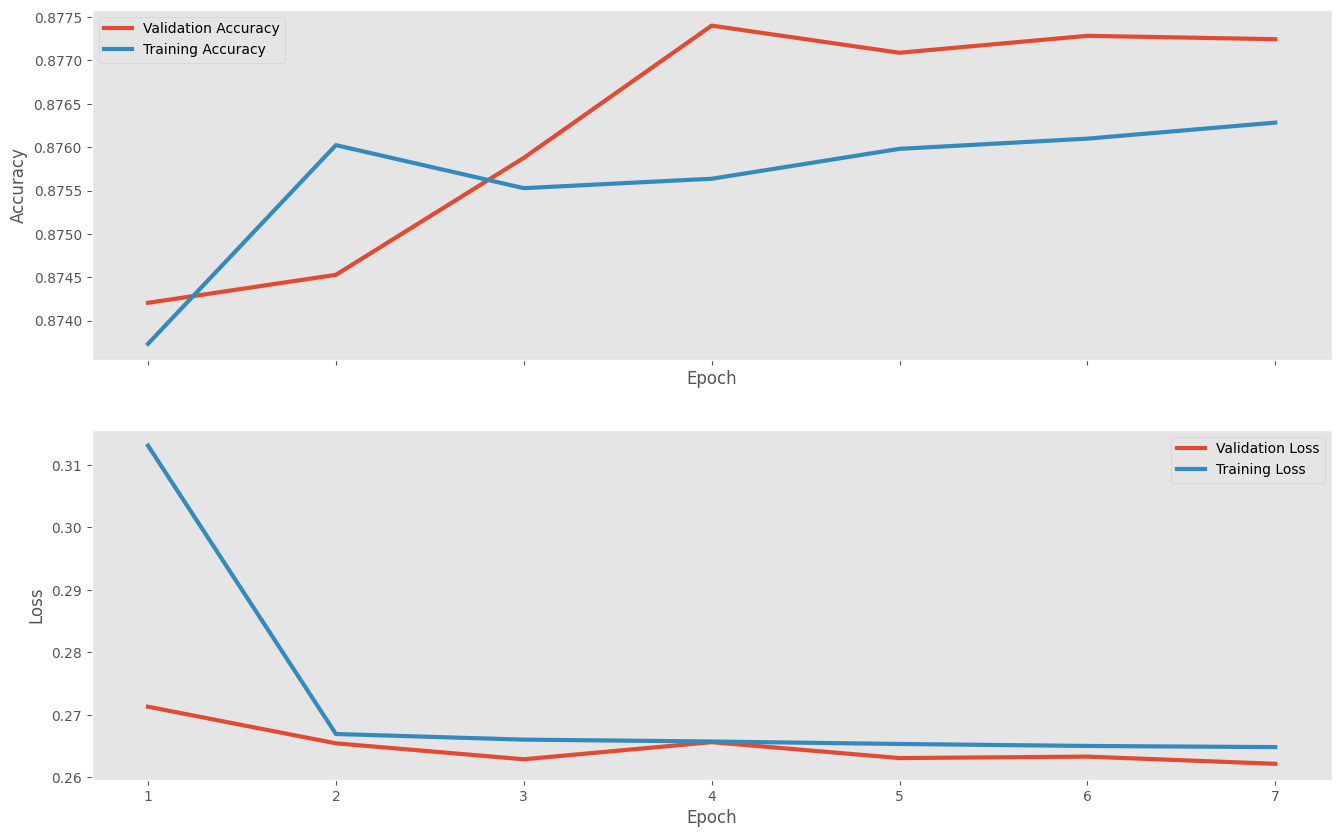

In [49]:
plot_results(history_dnn)

In [50]:
dnn.save("../models/dnn.h5")

In [51]:
load_dnn = load_model("../models/dnn.h5")

3366/3366 [==============================] - 3s 948us/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     87579
           1       0.68      0.66      0.67     20124

    accuracy                           0.88    107703
   macro avg       0.80      0.79      0.80    107703
weighted avg       0.88      0.88      0.88    107703


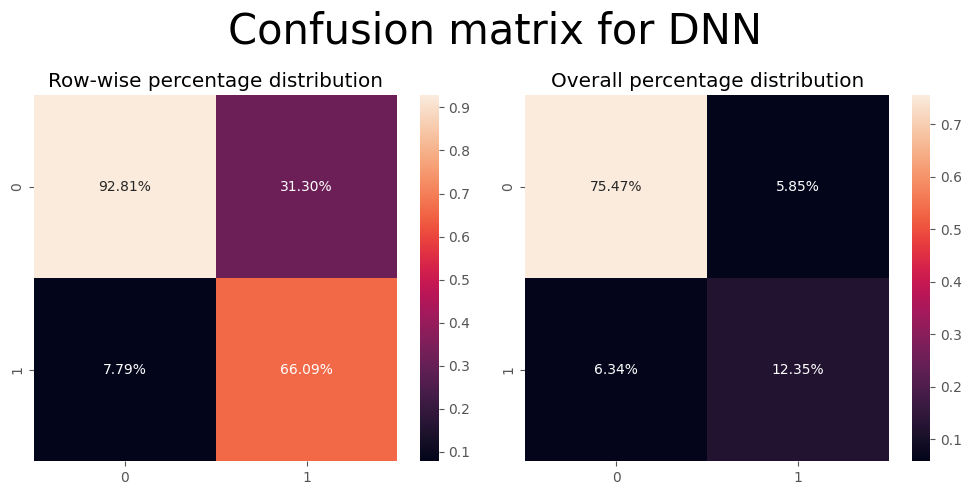

3366/3366 [==============================] - 3s 1ms/step - loss: 0.2616 - accuracy: 0.8782
DNN: Loss is 0.2615776062011719, Accuracy is 0.8781556487083435


In [52]:
y_pred_dnn = load_dnn.predict(X_test_processed)
y_pred_dnn_bin = (y_pred_dnn > 0.5).astype('int32')

print(classification_report(y_test, y_pred_dnn_bin))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_dnn = confusion_matrix(y_test, y_pred_dnn_bin)
cm_dnn_perc = cm_dnn / cm_dnn.sum(axis=1)

sns.heatmap(cm_dnn_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_dnn_bin, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for DNN", fontsize=30)
plt.tight_layout()
plt.show()

loss, accuracy = dnn.evaluate(X_test_processed, y_test)
print(f"DNN: Loss is {loss}, Accuracy is {accuracy}")

### RNN

In [53]:
rnn = Sequential()

rnn.add(Bidirectional(LSTM(units=4, return_sequences=True), input_shape=(X_train_processed.shape[1], 1)))
#rnn.add(Activation(swish))
rnn.add(Dropout(0.2))

rnn.add(Bidirectional(LSTM(units=4, return_sequences=True)))
#rnn.add(Activation(swish))
rnn.add(Dropout(0.2))
rnn.add(BatchNormalization())

# Output layer for binary classification
rnn.add(Dense(1, activation='sigmoid'))
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 175, 8)            192       
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 175, 8)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 175, 8)            416       
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 175, 8)            0         
                                                                 
 batch_normalization_3 (Bat  (None, 175, 8)            32        
 chNormalization)                                                
                                                      

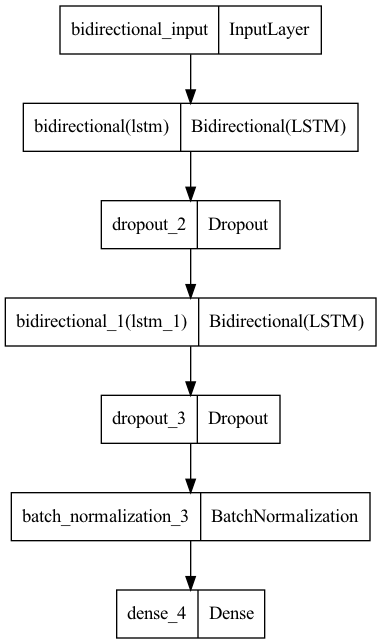

In [54]:
plot_model(rnn, to_file="../rnn.png")

In [55]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
with tf.device('/cpu:0'):
    history_rnn = rnn.fit(X_train_processed, y_train, epochs=10, batch_size=128, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/10
15188/15188 [==============================] - 611s 40ms/step - loss: 0.4467 - accuracy: 0.8110 - val_loss: 0.4298 - val_accuracy: 0.8121
Epoch 2/10
15188/15188 [==============================] - 585s 38ms/step - loss: 0.3780 - accuracy: 0.8156 - val_loss: 0.3000 - val_accuracy: 0.8493
Epoch 3/10
15188/15188 [==============================] - 567s 37ms/step - loss: 0.3518 - accuracy: 0.8243 - val_loss: 0.2932 - val_accuracy: 0.8601
Epoch 4/10
15188/15188 [==============================] - 566s 37ms/step - loss: 0.3478 - accuracy: 0.8209 - val_loss: 0.2916 - val_accuracy: 0.8559
Epoch 5/10
15188/15188 [==============================] - 559s 37ms/step - loss: 0.3225 - accuracy: 0.8404 - val_loss: 0.2879 - val_accuracy: 0.8683
Epoch 6/10
15188/15188 [==============================] - 560s 37ms/step - loss: 0.2907 - accuracy: 0.8614 - val_loss: 0.2702 - val_accuracy: 0.8747
Epoch 7/10
15188/15188 [==============================] - 814s 54ms/step - loss: 0.2785 - accuracy: 0.8692

In [57]:
rnn.save("../models/rnn.h5")
load_rnn = load_model("../models/rnn.h5")

3366/3366 [==============================] - 27s 8ms/step


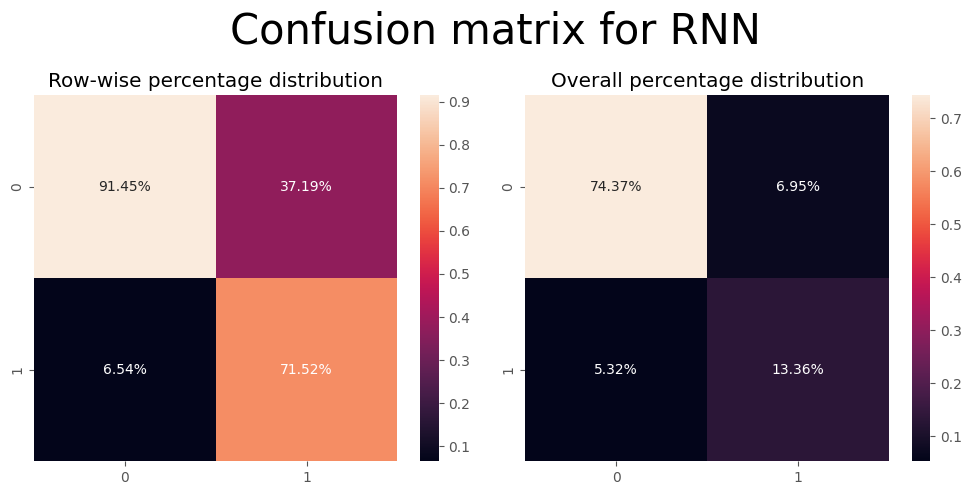

3366/3366 [==============================] - 33s 10ms/step - loss: 0.2568 - accuracy: 0.8780
RNN: Loss is 0.2567703127861023, Accuracy is 0.8779556155204773


In [58]:
y_pred_rnn = load_rnn.predict(X_test_processed)
y_pred_rnn_bin = []

for i in y_pred_rnn:
  if (i > 0.5).any():
     y_pred_rnn_bin.append(1)
  else:
     y_pred_rnn_bin.append(0)

cm_rnn = confusion_matrix(y_test, y_pred_rnn_bin)
cm_rnn_perc = cm_rnn / cm_rnn.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(cm_rnn_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_rnn_bin, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for RNN", fontsize=30)
plt.tight_layout()
plt.show()

loss_2, accuracy_2 = load_rnn.evaluate(X_test_processed, y_test)
print(f"RNN: Loss is {loss_2}, Accuracy is {accuracy_2}")

### Ensemble model

In [6]:
# DNN
input_dnn = Input(shape=(X_train_processed.shape[1],))
x_dnn = Dense(1024, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(input_dnn)

x_dnn = Dense(512, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)

x_dnn = Dense(256, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)

x_dnn = Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.001))(x_dnn)
x_dnn = Dropout(0.5)(x_dnn)
x_dnn = BatchNormalization()(x_dnn)

# RNN
input_rnn = Input(shape=(X_train_processed.shape[1], 1))
x_rnn = Bidirectional(LSTM(units=8, return_sequences=True))(input_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)

x_rnn = Bidirectional(LSTM(units=8, return_sequences=True))(input_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)

x_rnn = Bidirectional(LSTM(units=8, return_sequences=False))(x_rnn)
x_rnn = Activation(swish)(x_rnn)
x_rnn = Dropout(0.5)(x_rnn)
x_rnn = BatchNormalization()(x_rnn)

# Concat
combined = concatenate([x_dnn, x_rnn])

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(combined)

In [7]:
ensemble_model = Model(inputs=[input_dnn, input_rnn], outputs=output)
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 175)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 1024)                 180224    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 175, 1)]             0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 512)                  524800    ['dense[0][0]']               
                                                                                              

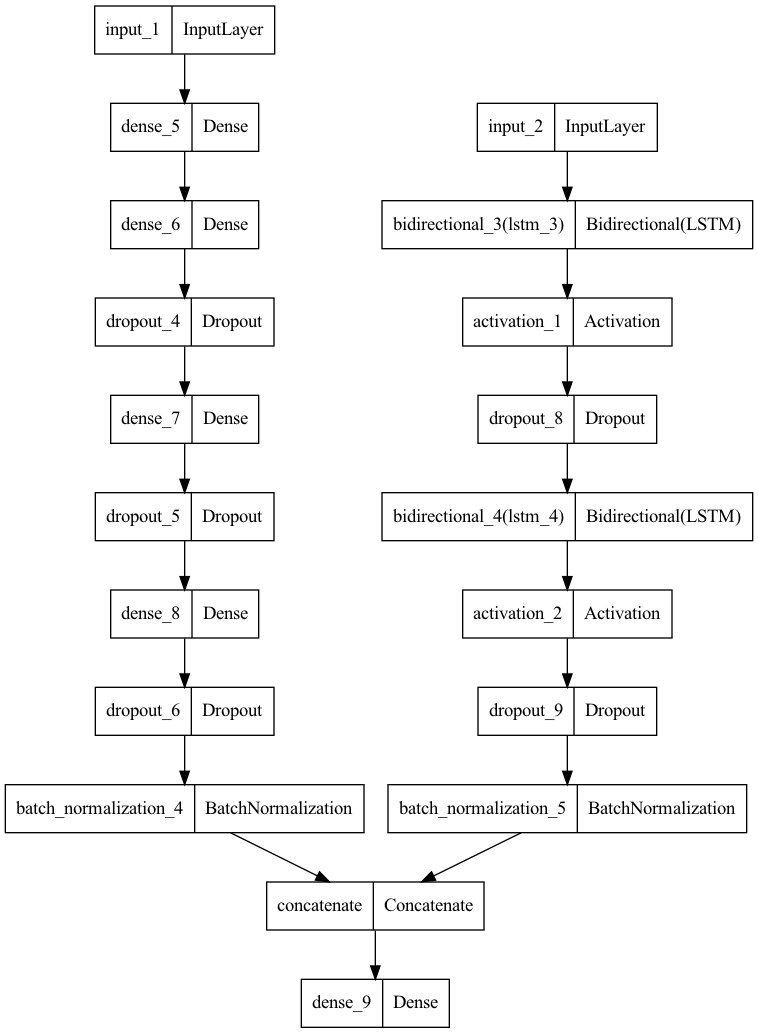

In [61]:
plot_model(ensemble_model, to_file="../ensemble.png")

In [11]:
optimizer = Adam(learning_rate=0.001)

ensemble_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
with tf.device('/cpu:0'):
    history_ens = ensemble_model.fit([X_train_processed, X_train_processed], y_train, epochs=10, batch_size=128, validation_split=0.05, callbacks=[early_stopping])

Epoch 1/10
15188/15188 [==============================] - 1136s 75ms/step - loss: 0.3095 - accuracy: 0.8733 - val_loss: 0.2654 - val_accuracy: 0.8772
Epoch 2/10
15188/15188 [==============================] - 1001s 66ms/step - loss: 0.2715 - accuracy: 0.8742 - val_loss: 0.2668 - val_accuracy: 0.8732
Epoch 3/10
15188/15188 [==============================] - 907s 60ms/step - loss: 0.2693 - accuracy: 0.8746 - val_loss: 0.2628 - val_accuracy: 0.8765
Epoch 4/10
15188/15188 [==============================] - 873s 58ms/step - loss: 0.2691 - accuracy: 0.8746 - val_loss: 0.2643 - val_accuracy: 0.8751


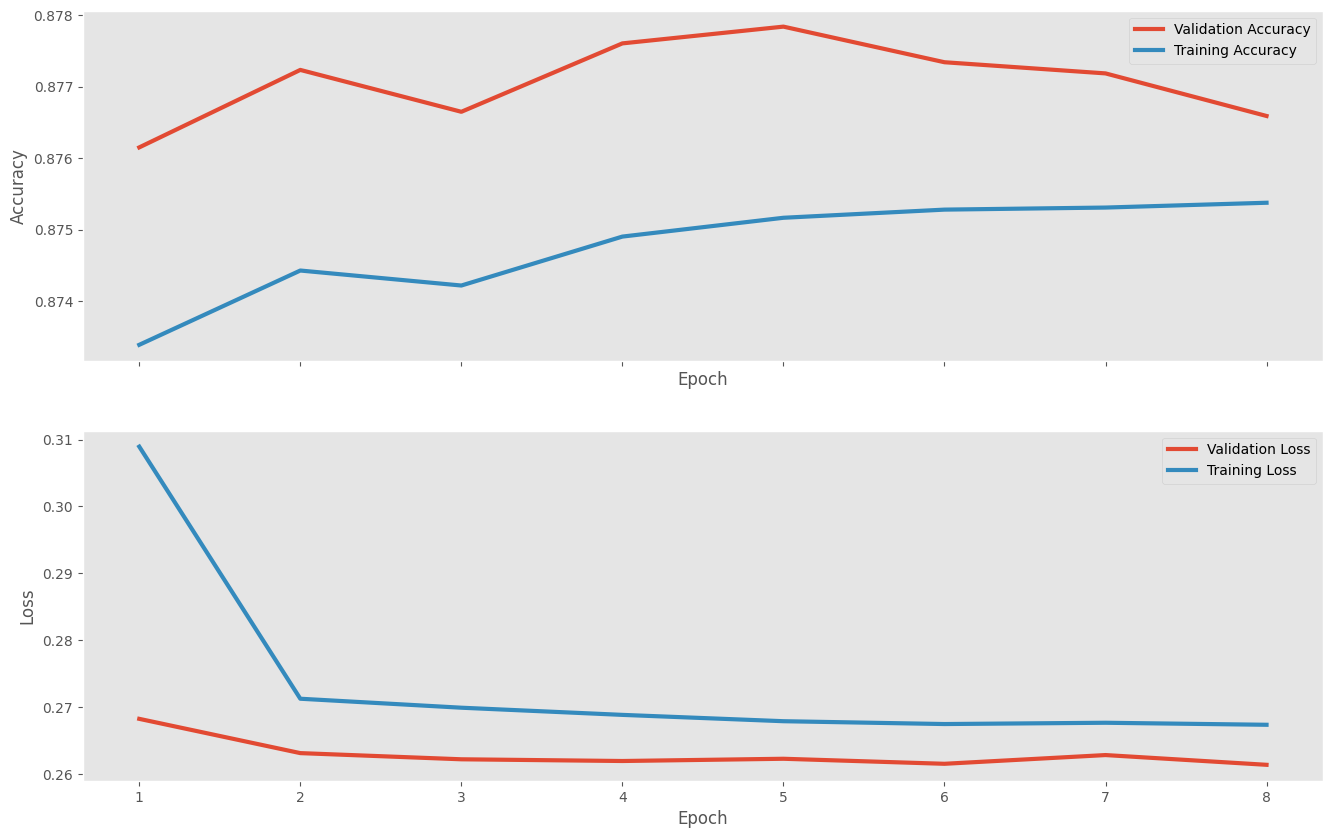

In [64]:
plot_results(history_ens)

In [13]:
ensemble_model.save("../models/ensemble.h5")
load_ens = load_model("../models/ensemble.h5")

3366/3366 [==============================] - 31s 9ms/step


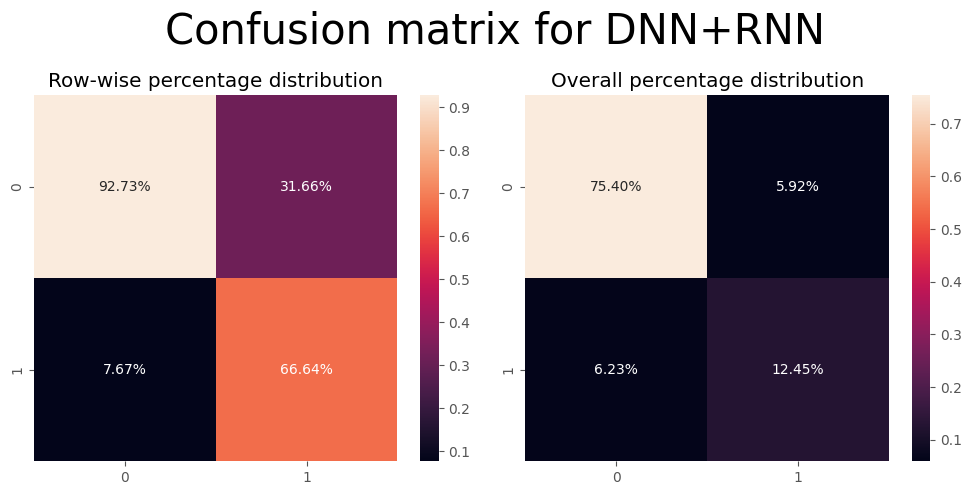

3366/3366 [==============================] - 32s 9ms/step - loss: 0.2582 - accuracy: 0.8785
Ensemble: Loss is 0.25821641087532043, Accuracy is 0.878517746925354


In [66]:
y_pred_ens = load_ens.predict([X_test_processed, X_test_processed])
y_pred_ens_bin = (y_pred_ens > 0.5).astype('int32')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cm_ens = confusion_matrix(y_test, y_pred_ens_bin)
cm_ens_perc = cm_ens / cm_ens.sum(axis=1)

sns.heatmap(cm_ens_perc, annot=True, fmt='.2%', ax=axes[0])
axes[0].set_title("Row-wise percentage distribution")
sns.heatmap(confusion_matrix(y_test, y_pred_ens_bin, normalize='all'), annot=True, fmt='.2%', ax=axes[1])
axes[1].set_title("Overall percentage distribution")

plt.suptitle("Confusion matrix for DNN+RNN", fontsize=30)
plt.tight_layout()
plt.show()

loss_3, accuracy_3 = load_ens.evaluate([X_test_processed, X_test_processed], y_test)
print(f"Ensemble: Loss is {loss_3}, Accuracy is {accuracy_3}")

# Models Evaluation

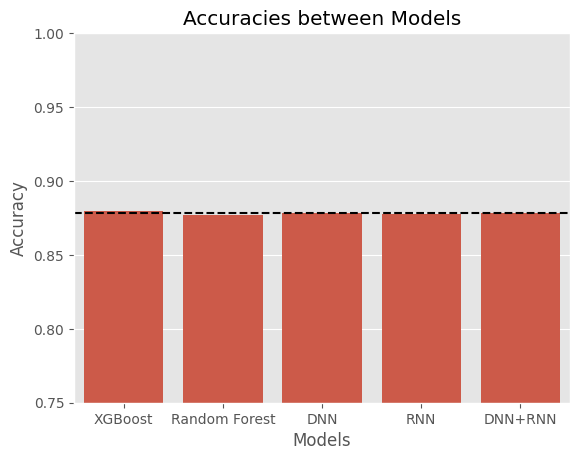

In [77]:
# Make a graph on all accuracies
accs_dict = {
    "XGBoost": [acc_xgb],
    "Random Forest": [acc_rf],
    "DNN": [accuracy],
    "RNN": [accuracy_2],
    "DNN+RNN": [accuracy_3]
}

accs_df = pd.DataFrame.from_dict(accs_dict, orient='index', columns=["Accuracies"])

ax = sns.barplot(data=accs_df, x=accs_df.index, y='Accuracies')

dnn_rnn_accuracy = accs_df.loc["DNN+RNN",:][0]
ax.axhline(y=dnn_rnn_accuracy, color='black', linestyle='--', label='DNN+RNN Accuracy')

plt.ylim(0.75, 1)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracies between Models")
plt.show()

> Comment: Surprisingly, The ensemble model did not show a huge improvement like we anticipated.

# Conclusion

In this project, we set out to develop predictive models for telecom customer churn. Our project included EDA, data preprocessing, and the training and evaluation of both ML and DL models.

The results of our efforts with ML models were successful, achieving good accuracy even in the challenging context of imbalanced data. These models established the foundation to compare the DL models.

However, DL models did not yield the expected performances. One of the key challenges was determining the most optimal deep learning architecture for our specific use case. DL models often require extensive hyperparameter tuning and architecture experimentation, which we were unable to fully explore in this project.

In conclusion, there are rooms for improvements in fine-tuning our DL models for better performances.
